In [1]:
import os
import sys
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))
import random
from collections import defaultdict, namedtuple
import itertools


import numpy as np
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas
import colorcet as cc
import cv2
import pandas as pd

from IPython.display import display, Markdown, Latex

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

# from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
import tabulate


from simple_relational_reasoning.embeddings.stimuli import PatchStimulusGenerator
from simple_relational_reasoning.embeddings.triplets import QuinnTripletGenerator
from simple_relational_reasoning.embeddings.task import run_multiple_models_multiple_generators
from simple_relational_reasoning.embeddings.tables import table_per_relation_multiple_results
from simple_relational_reasoning.embeddings.models import RESNEXT, MOBILENET

# from quinn_embedding_models import *
# from quinn_embedding_triplets import *
# from quinn_embedding_task import *
# from quinn_embedding_tables import *
# from quinn_embedding_visualizations import *


In [2]:
RANDOM_SEED = 33
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = 'cpu'

## Object generator and sample

In [3]:
def plot_generator_examples(generator):
    plt.figure(figsize=(generator.n_target_types * 2.5, 3))

    for i in range(generator.n_target_types):
        x = generator.generate((30, 30 + (i * 30)), reference_positions, target_index=i)
        ax = plt.subplot(1, generator.n_target_types, i +1)
        ax.imshow(x.permute(1, 2, 0).numpy())


    plt.show()

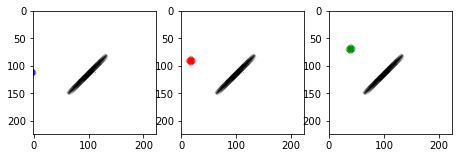

In [4]:
target_size = 15
reference_size = (10, 100)
reference_positions = [(105, 100)]

blue_target_patch = matplotlib.patches.Circle((0, 0), target_size // 2, color='blue')
red_target_patch = matplotlib.patches.Circle((0, 0), target_size // 2, color='red')
green_target_patch = matplotlib.patches.Circle((0, 0), target_size // 2, color='green')
reference_patch = matplotlib.patches.Ellipse((0, 0), width=reference_size[1], 
                                             height=reference_size[0], color='black')

blur_func = lambda x: cv2.blur(x, (5, 5))

# gen = NaiveStimulusGenerator(target_size, refernce_size, target_color='black', dtype=torch.float32)
gen = PatchStimulusGenerator(target_size, reference_size, [blue_target_patch, red_target_patch, green_target_patch], 
                             reference_patch, blur_func=blur_func, rotate_angle=45)

plot_generator_examples(gen)

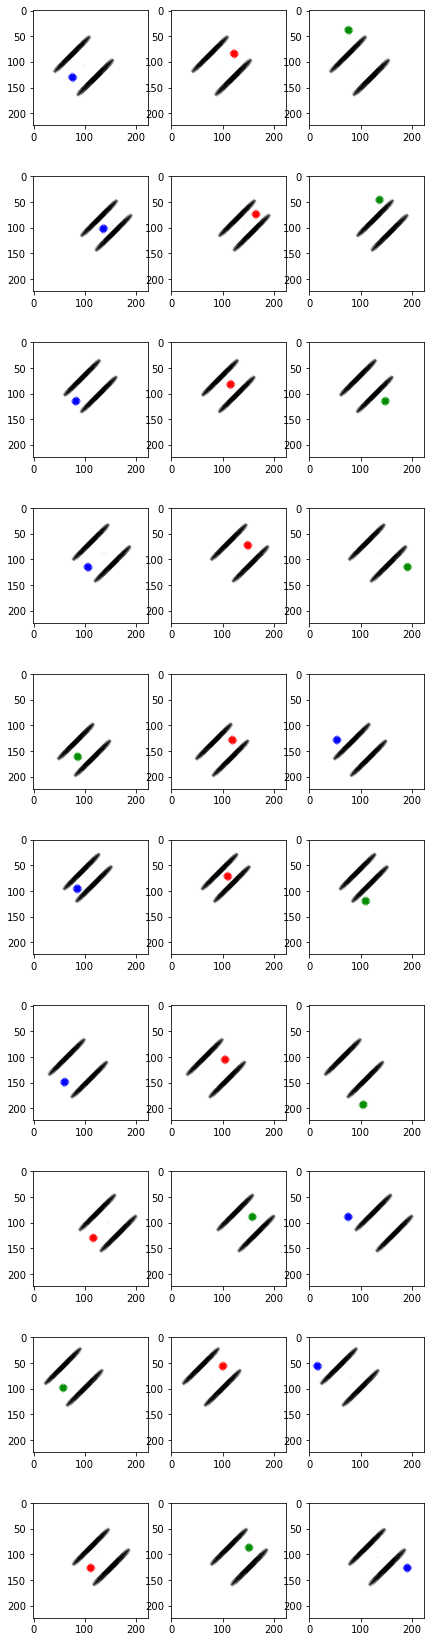

In [5]:
N = 10

above_below_quinn_gen = QuinnTripletGenerator(gen, (30, 70), 
    relation='between', two_reference_objects=True, n_target_types=3,
    extra_diagonal_margin=10)
results = above_below_quinn_gen(N, normalize=False)
plt.figure(figsize=(7, 3 * N))

for row in range(N):
    for col in range(3):
        ax = plt.subplot(N, 3, (3 * row) + col + 1)
        x = results[row, col]
        centroid = tuple((x == torch.tensor([1, 0.27, 0]).view(3, 1, 1)).all(axis=0).nonzero().squeeze().numpy())
        
        # print(centroid, above_below_quinn_gen.centroids[row])
        ax.imshow(x.permute(1, 2, 0).numpy())

plt.show()


[61 57] (109, 108) (61, 57)


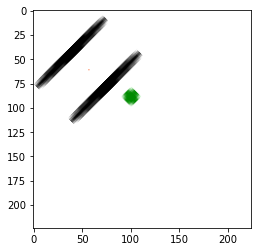

In [32]:
new_centroid = tuple((x == torch.tensor([1, 0.27, 0]).view(3, 1, 1)).all(axis=0).nonzero().squeeze().numpy())
original_centroid = above_below_quinn_gen.centroids[-1]

shape = gen.canvas_size
x_cropped = transforms.functional.crop(x, *(new_centroid - original_centroid), *shape)

post_crop_centroid = tuple((x_cropped == torch.tensor([1, 0.27, 0]).view(3, 1, 1)).all(axis=0).nonzero().squeeze().numpy())
print(original_centroid, new_centroid, post_crop_centroid)

plt.imshow(x_cropped.permute(1, 2, 0).numpy())

In [ ]:
post_crop_centroid.shape

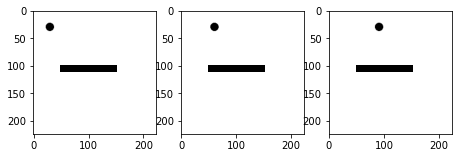

In [8]:
target_size = 15
reference_size = (10, 100)
target_patch_1 = matplotlib.patches.Circle((0, 0), target_size // 2, color='black')
target_patch_2 = matplotlib.patches.Circle((0, 0), target_size // 2, color='black')
target_patch_3 = matplotlib.patches.Circle((0, 0), target_size // 2, color='black')
rectangle_reference_patch = matplotlib.patches.Rectangle(
    (-reference_size[1] // 2, -reference_size[0] // 2), reference_size[1], reference_size[0], color='black')


# gen = NaiveStimulusGenerator(target_size, refernce_size, target_color='black', dtype=torch.float32)
dot_and_bar_gen = PatchStimulusGenerator(target_size, reference_size, 
                                         [target_patch_1, target_patch_2, target_patch_3], 
                                         rectangle_reference_patch)

plot_generator_examples(dot_and_bar_gen)

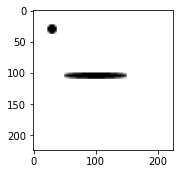

In [9]:
target_patch = matplotlib.patches.Circle((0, 0), target_size // 2, color='black')
reference_patch = matplotlib.patches.Ellipse((0, 0), width=reference_size[1], 
                                             height=reference_size[0], color='black')

blur_func = lambda x: cv2.blur(x, (5, 5))

# gen = NaiveStimulusGenerator(target_size, refernce_size, target_color='black', dtype=torch.float32)
same_color_gen = PatchStimulusGenerator(target_size, reference_size, [target_patch], 
                                        reference_patch, blur_func=blur_func)

plot_generator_examples(same_color_gen)

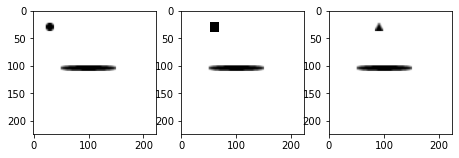

In [10]:
target_size = 15
reference_size = (10, 100)
reference_positions = [(105, 100)]

circle_patch = matplotlib.patches.Circle((0, 0), target_size // 2, color='black')
square_patch = matplotlib.patches.Rectangle((-target_size // 2, -target_size // 2), target_size, target_size, color='black')
triangle_patch = matplotlib.patches.RegularPolygon((0, 0), 3, target_size // 2, color='black')
reference_patch = matplotlib.patches.Ellipse((0, 0), width=reference_size[1], 
                                             height=reference_size[0], color='black')

blur_func = lambda x: cv2.blur(x, (5, 5))

# gen = NaiveStimulusGenerator(target_size, refernce_size, target_color='black', dtype=torch.float32)
different_shapes_gen = PatchStimulusGenerator(target_size, reference_size, 
                                              [circle_patch, square_patch, triangle_patch], 
                                              reference_patch, blur_func=blur_func)

plot_generator_examples(different_shapes_gen)

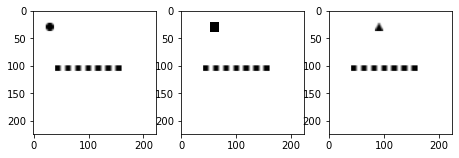

In [17]:
target_size = 15
reference_box_size = 8
total_reference_size = (10, 120)
reference_positions = [(105, 100)]

circle_patch = matplotlib.patches.Circle((0, 0), target_size // 2, color='black')
square_patch = matplotlib.patches.Rectangle((-target_size // 2, -target_size // 2), target_size, target_size, color='black')
triangle_patch = matplotlib.patches.RegularPolygon((0, 0), 3, target_size // 2, color='black')

reference_patches = [matplotlib.patches.Rectangle(((-reference_box_size // 2) + (reference_box_size * 2 * i), 
                                                   (-reference_box_size // 2)), 
                                                  reference_box_size, reference_box_size, color='black')
                    for i in range(7)]


blur_func = lambda x: cv2.blur(x, (5, 5))

# gen = NaiveStimulusGenerator(target_size, refernce_size, target_color='black', dtype=torch.float32)
split_reference_gen = PatchStimulusGenerator(target_size, total_reference_size, 
                                              [circle_patch, square_patch, triangle_patch], 
                                              reference_patches, blur_func=blur_func,
                                            #   reference_patch_kwargs=dict(ylim=(-70, 70))
                                              )

plot_generator_examples(split_reference_gen)

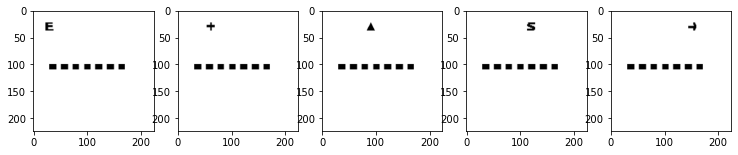

In [18]:
target_size = (15, 15)
reference_box_size = 8
total_reference_size = (10, 140)
reference_positions = [(105, 100)]

triangle_patch = matplotlib.patches.RegularPolygon((0, 0), 3, target_size[0] // 2, color='black')

reference_patches = [matplotlib.patches.Rectangle(((-reference_box_size // 2) + (reference_box_size * 2 * i), 
                                                   (-reference_box_size // 2)), 
                                                  reference_box_size, reference_box_size, color='black')
                    for i in range(7)]


blur_func = lambda x: cv2.blur(x, (5, 5))

# gen = NaiveStimulusGenerator(target_size, refernce_size, target_color='black', dtype=torch.float32)
split_reference_text_gen = PatchStimulusGenerator(target_size, total_reference_size, 
                                              ['E', '$+$', triangle_patch, 's', '$\\to$'], 
                                              reference_patches, # blur_func=blur_func,
                                            #   reference_patch_kwargs=dict(ylim=(-70, 70))
                                              )

plot_generator_examples(split_reference_text_gen)

## Triplet generators

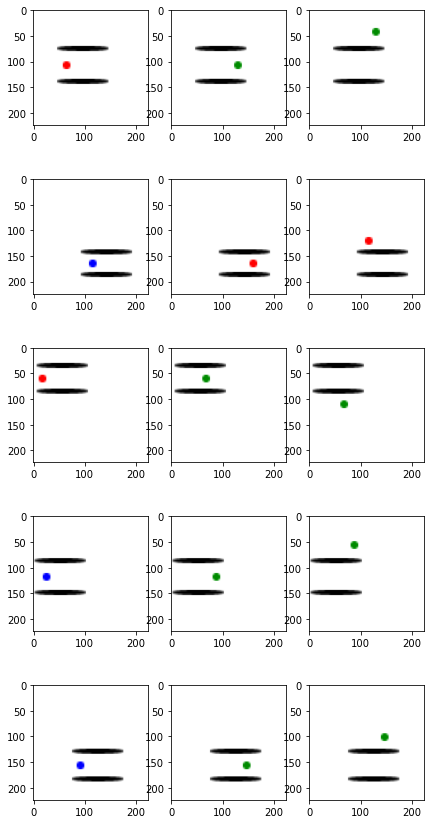

In [24]:
N = 5

above_below_quinn_gen = QuinnTripletGenerator(gen, (30, 70), 
    relation='between', two_reference_objects=True, n_target_types=2)
results = above_below_quinn_gen(N, normalize=False)
plt.figure(figsize=(7, 3 * N))

for row in range(N):
    for col in range(3):
        ax = plt.subplot(N, 3, (3 * row) + col + 1)
        ax.imshow(results[row, col].permute(1, 2, 0).numpy())

plt.show()


In [ ]:
N = 5

above_below_quinn_gen = QuinnTripletGenerator(split_reference_text_gen, (30, 70), 
                                              two_reference_objects=True, 
                                              n_target_types=2, transpose=True)
results = above_below_quinn_gen(N, normalize=False)
plt.figure(figsize=(7, 3 * N))

for row in range(N):
    for col in range(3):
        ax = plt.subplot(N, 3, (3 * row) + col + 1)
        ax.imshow(results[row, col].permute(1, 2, 0).numpy())

plt.show()


## Metric functions

## Actual task implementation

In [ ]:
def default_name_func(generator_kwargs, base_name=''):
    two_reference_objects = generator_kwargs['two_reference_objects']
    transpose = generator_kwargs['transpose']
    
    if two_reference_objects:
        if transpose:
            rel_name = 'VerticalBetween'
        else:
            rel_name = 'Between'
    else:
        if transpose:
            rel_name = 'Left/Right'
        else:
            rel_name = 'Above/Below'
    
    name = f'{base_name}{base_name and "-" or ""}{rel_name}'
            
    n_target_types = None
    if 'n_target_types' in generator_kwargs:
        n_target_types = generator_kwargs['n_target_types']
        return name + f'-{n_target_types}-types'
    
    return name


def create_generators_and_names(triplet_generator_class, stimulus_generator, kwarg_value_sets, 
                                name_func=default_name_func, name_func_kwargs=None):
    if name_func_kwargs is None:
        name_func_kwargs = {}
    
    names = []
    triplet_generators = []

    for value_set in itertools.product(*kwarg_value_sets.values()):
        kwargs = {k: v for (k, v) in zip(kwarg_value_sets.keys(), value_set)}
        names.append(name_func(kwargs, **name_func_kwargs))
        triplet_generators.append(triplet_generator_class(stimulus_generator, **kwargs))

    return names, triplet_generators
    

In [ ]:
QUINN_DISTANCE_ENDPOINTS = (30, 70)

quinn_default_value_sets = dict(
    distance_endpoints=(QUINN_DISTANCE_ENDPOINTS,),
    two_reference_objects=(False, True),
    transpose=(False, True),
    n_target_types=range(1, 4)
)

quinn_names, quinn_triplet_generators = create_generators_and_names(
    QuinnTripletGenerator, gen, quinn_default_value_sets, name_func_kwargs=dict(base_name='Quinn'))

In [ ]:
model_kwarg_dicts = (
    dict(name=MOBILENET, device=device, pretrained=False, saycam='S'),
    dict(name=MOBILENET, device=device, pretrained=True),
    dict(name=MOBILENET, device=device, pretrained=False),
    dict(name=RESNEXT, device=device, pretrained=False, saycam='S'),
    dict(name=RESNEXT, device=device, pretrained=True),
    dict(name=RESNEXT, device=device, pretrained=False),
)

model_names = [ f'{d["name"]}-{"saycam" in d and "saycam(S)" or (d["pretrained"] and "imagenet" or "random")}'
               for d in model_kwarg_dicts]


In [ ]:
N = 1024
quinn_generators_all_model_results = run_multiple_models_multiple_generators(
    model_names, model_kwarg_dicts, quinn_names, quinn_triplet_generators, N)

In [ ]:
display_multiple_model_results_multiple_types('Quinn', quinn_generators_all_model_results, tablefmt='github')

In [ ]:
quinn_single_color_value_sets = dict(
    distance_endpoints=(QUINN_DISTANCE_ENDPOINTS,),
    two_reference_objects=(False, True),
    transpose=(False, True),
)

quinn_single_color_names, quinn_single_color_triplet_generators = create_generators_and_names(
    QuinnTripletGenerator, same_color_gen, quinn_single_color_value_sets, name_func_kwargs=dict(base_name='Quinn-Single-Color'))


In [ ]:
N = 1024
quinn_generators_single_color_results = run_multiple_models_multiple_generators(
    model_names, model_kwarg_dicts, quinn_single_color_names, quinn_single_color_triplet_generators, N)

In [ ]:
display_multiple_model_results_single_type('Quinn Single Color', quinn_generators_single_color_results, tablefmt='github')

In [ ]:
quinn_different_shape_names, quinn_different_shape_triplet_generators = create_generators_and_names(
    QuinnTripletGenerator, different_shapes_gen, quinn_default_value_sets, name_func_kwargs=dict(base_name='Quinn-Diff-Shapes'))

In [ ]:
N = 1024
quinn_generators_different_shapes_results = run_multiple_models_multiple_generators(
    model_names, model_kwarg_dicts, quinn_different_shape_names, quinn_different_shape_triplet_generators, N)

In [ ]:
display_multiple_model_results_multiple_types('Quinn Different Shapes', quinn_generators_different_shapes_results, tablefmt='github')

In [ ]:
quinn_split_reference_names, quinn_split_reference_triplet_generators = create_generators_and_names(
    QuinnTripletGenerator, split_reference_gen, quinn_default_value_sets, name_func_kwargs=dict(base_name='Quinn-Split-Reference'))

In [ ]:
N = 1024
quinn_generators_split_reference_results = run_multiple_models_multiple_generators(
    model_names, model_kwarg_dicts, quinn_split_reference_names, quinn_split_reference_triplet_generators, N)

In [ ]:
display_multiple_model_results_multiple_types('Quinn Split Reference', quinn_generators_split_reference_results, tablefmt='github')

In [ ]:
quinn_split_reference_text_names, quinn_split_reference_text_triplet_generators = create_generators_and_names(
    QuinnTripletGenerator, split_reference_text_gen, quinn_default_value_sets, name_func_kwargs=dict(base_name='Quinn-Split-Reference-Text'))

In [ ]:
N = 1024
quinn_generators_split_reference_text_results = run_multiple_models_multiple_generators(
    model_names, model_kwarg_dicts, quinn_split_reference_text_names, quinn_split_reference_text_triplet_generators, N)

In [ ]:
display_multiple_model_results_multiple_types('Quinn Split Reference Text Target', quinn_generators_split_reference_text_results, tablefmt='github')

In [ ]:
def build_random_color_stimulus_generator(rng, cmap=cc.cm.glasbey, cmap_range=(0, 255),
                                         target_size=20, reference_size=(10, 100)):
    start_int = rng.integers(cmap_range[0], cmap_range[1] - 4)

    blue_target_patch = matplotlib.patches.Circle((0, 0), target_size // 2, 
                                                  color=cmap(start_int))
    red_target_patch = matplotlib.patches.Circle((0, 0), target_size // 2,
                                                 color=cmap(start_int + 1))
    green_target_patch = matplotlib.patches.Circle((0, 0), target_size // 2,
                                                   color=cmap(start_int + 2))
    reference_patch = matplotlib.patches.Ellipse((0, 0), width=reference_size[1], 
                                                 height=reference_size[0], 
                                                 color=cmap(start_int + 3))

    blur_func = lambda x: cv2.blur(x, (5, 5))

    return PatchStimulusGenerator(target_size, reference_size, 
                                  [blue_target_patch, red_target_patch, green_target_patch], 
                                  reference_patch, blur_func=blur_func)


In [ ]:
C = 10
N = 1024
all_random_color_names = []
all_random_color_triplet_generators = []
random_color_results = []

for c in range(C):
    print(c)
    rng = np.random.default_rng(c)
    random_gen = build_random_color_stimulus_generator(rng)
    
    random_color_names, random_color_triplet_generators = create_generators_and_names(
        QuinnTripletGenerator, random_gen, quinn_default_value_sets, name_func_kwargs=dict(base_name='Quinn-Random-Color'))
    
    all_random_color_names.append(random_color_names)
    all_random_color_triplet_generators.append(random_color_triplet_generators)
    
    random_color_results.append(run_multiple_models_multiple_generators(
        model_names, model_kwarg_dicts, random_color_names, random_color_triplet_generators, N))

In [ ]:
display_multiple_model_results_multiple_types_replications('Quinn Random Color Replications', random_color_results)

In [ ]:
result_set = (quinn_generators_split_reference_text_results, 
              quinn_generators_different_shapes_results,
              random_color_results)
df = table_per_relation_multiple_results(result_set, print_std=False, tablefmt='latex_raw')

In [ ]:
df.head()

In [ ]:
df.rendering.unique()

In [ ]:
above_below_df = filter_and_group(df, 
                 {'relation': 'above_below', 'dataset': ['saycam', 'imagenet']}, 
                 ['dataset', 'model_name', 'n_target_types'])

between_df = filter_and_group(df, 
                 {'relation': 'between', 'dataset': ['saycam', 'imagenet']}, 
                 ['dataset', 'model_name', 'n_target_types'])


horizontal_mean_diff =  between_df.mean() - above_below_df.mean()
horizontal_mean_diff.acc_mean

In [ ]:
fig = plt.figure(figsize=(20, 8), dpi=200)
fig.subplots_adjust(wspace=0.1)

text_kwargs = {'fontsize': 32}

above_below_ax = plt.subplot(1, 2, 1)
create_bar_chart(df, 
                 {'relation': 'above_below', 'dataset': ['saycam', 'imagenet']}, 
                 ['dataset', 'model_name', 'n_target_types'],
                 legend_loc='lower right', plot_std=False,
                 title='Above/Below', legend=False,
                 text_kwargs=text_kwargs, bar_spacing=0.3, 
                 title_kwargs=dict(fontweight='bold'),
                 ax=above_below_ax)

between_ax = plt.subplot(1, 2, 2)
create_bar_chart(df, 
                 {'relation': 'between', 'dataset': ['saycam', 'imagenet']}, 
                 ['dataset', 'model_name', 'n_target_types'],
                 legend_loc='lower right', plot_std=False,
                 title='Between', ylabel='', legend_ncol=1,
                 text_kwargs=text_kwargs, bar_spacing=0.3,
                 above_bar_texts=horizontal_mean_diff.acc_mean,
                 above_bar_text_spacing=0.03, above_bar_text_fontsize=18, 
                 title_kwargs=dict(fontweight='bold'),
                 ax=between_ax)

save_plot('exp2_horizontal_reference_bar_charts.pdf')

plt.show()

In [ ]:
left_right_df = filter_and_group(df, 
                 {'relation': 'left_right', 'dataset': ['saycam', 'imagenet']}, 
                 ['dataset', 'model_name', 'n_target_types'])

vertical_between_df = filter_and_group(df, 
                 {'relation': 'vertical_between', 'dataset': ['saycam', 'imagenet']}, 
                 ['dataset', 'model_name', 'n_target_types'])


vertical_mean_diff =  vertical_between_df.mean() - left_right_df.mean()
vertical_mean_diff.acc_mean

In [ ]:
fig = plt.figure(figsize=(20, 8), dpi=200)
fig.subplots_adjust(wspace=0.1)

text_kwargs = {'fontsize': 32}

left_right_ax = plt.subplot(1, 2, 1)
create_bar_chart(df, 
                 {'relation': 'left_right', 'dataset': ['saycam', 'imagenet']}, 
                 ['dataset', 'model_name', 'n_target_types'],
                 legend_loc='lower right', plot_std=False,
                 title='Left/Right', legend=False,
                 text_kwargs=text_kwargs, bar_spacing=0.3, 
                 title_kwargs=dict(fontweight='bold'),
                 ax=left_right_ax)

vertical_between_ax = plt.subplot(1, 2, 2)
create_bar_chart(df, 
                 {'relation': 'vertical_between', 'dataset': ['saycam', 'imagenet']}, 
                 ['dataset', 'model_name', 'n_target_types'],
                 legend_loc='upper right', plot_std=False,
                 title='Vertical-Between', ylabel='',
                 text_kwargs=text_kwargs, bar_spacing=0.3, legend_ncol=1,
                 above_bar_texts=vertical_mean_diff.acc_mean,
                 above_bar_text_spacing=0.03, above_bar_text_fontsize=18,
                 title_kwargs=dict(fontweight='bold'),
                 ax=vertical_between_ax)

save_plot('exp2_vertical_reference_bar_charts.pdf')

plt.show()

In [ ]:
for rendering in df.rendering.unique():
    fig = plt.figure(figsize=(20, 8), dpi=200)
    fig.subplots_adjust(wspace=0.1)

    text_kwargs = {'fontsize': 28}
    
    plt.suptitle(rendering, **text_kwargs)

    above_below_ax = plt.subplot(1, 2, 1)
    create_bar_chart(df, 
                     {'relation': 'above_below', 'dataset': ['saycam', 'imagenet'], 
                      'rendering': rendering}, 
                     ['dataset', 'model_name', 'n_target_types'],
                     legend_loc='lower right', plot_std=False,
                     title='$\\it{Above/Below}$', legend=False,
                     text_kwargs=text_kwargs, bar_spacing=0.3, 
                     ax=above_below_ax)

    between_ax = plt.subplot(1, 2, 2)
    create_bar_chart(df, 
                     {'relation': 'between', 'dataset': ['saycam', 'imagenet'],
                      'rendering': rendering}, 
                     ['dataset', 'model_name', 'n_target_types'],
                     legend_loc='lower right', plot_std=False,
                     title='$\\it{Between}$', ylabel='', legend_ncol=1,
                     text_kwargs=text_kwargs, bar_spacing=0.3,
                     ax=between_ax)

    plt.show()

# Recover min and max for untrained models

In [ ]:
filter_and_group(df, {'dataset': 'random'}, ['model_name']).acc_mean.describe()

# Visualizing example objects

In [ ]:
dot_and_bar_names, dot_and_bar_triplet_generators = create_generators_and_names(
    QuinnTripletGenerator, dot_and_bar_gen, quinn_default_value_sets, name_func_kwargs=dict(base_name='Quinn-Dot-and-Bar'))

triplet_generator_lists = (dot_and_bar_triplet_generators,
                           quinn_split_reference_text_triplet_generators, )

row_labels = ('Same\nTarget', 'Different\nTarget')

N_rows = len(triplet_generator_lists)

baseline_font_size = 28
side_rendering_labels = True
N = 5

fig = plt.figure(figsize=(18, 2.5 * N_rows), dpi=200)

row = 0
for triplet_generator_list in triplet_generator_lists:
    col = 0
    for trip_gen in triplet_generator_list:
        if trip_gen.n_target_types == 2 and not trip_gen.transpose:
            triplet = trip_gen(N, normalize=False)[-1]
            for sub_col in range(3):
                ax = plt.subplot(N_rows, 6, (row * 6) + (col * 3) + sub_col + 1)
                ax.imshow(triplet[sub_col].permute(1, 2, 0).numpy())
                ax.get_xaxis().set_ticks([])
                ax.get_yaxis().set_ticks([])
                if row == 0:
                    if sub_col == 0:
                        ax.set_title('Familiarization', fontsize=baseline_font_size - 6)
                    elif sub_col == 1:
                        ax.set_title('Same Relation', fontsize=baseline_font_size - 6)
                    else:
                        ax.set_title('Other Relation', fontsize=baseline_font_size - 6)
                if side_rendering_labels:
                    if col == 0 and sub_col == 0:
                        ax.set_ylabel(row_labels[row], fontsize=baseline_font_size, fontweight='bold')
            
            col += 1
        
    row += 1
        
fig.text(0.315, .99, 'Above/Below', fontsize=baseline_font_size, fontweight='bold',
        horizontalalignment='center', verticalalignment='center',)

fig.text(0.71, .99, 'Between', fontsize=baseline_font_size, fontweight='bold',
        horizontalalignment='center', verticalalignment='center',)

fig.subplots_adjust(wspace=0.1, hspace=0.01, bottom=0, top=0.9)
l1 = matplotlib.lines.Line2D([0.5125, 0.5125], [0, 1], transform=fig.transFigure, figure=fig, 
                             color='black', lw=3, ls='-')
    

fig.lines.append(l1)

save_plot(f'intro_example_stimuli.pdf')

plt.show()

In [ ]:
c = 23
rng = np.random.default_rng(c)
random_gen = build_random_color_stimulus_generator(rng)

random_color_names, random_color_triplet_generators = create_generators_and_names(
    QuinnTripletGenerator, random_gen, quinn_default_value_sets, name_func_kwargs=dict(base_name='Quinn-Random-Color'))

triplet_generator_lists = (quinn_different_shape_triplet_generators,
                           random_color_triplet_generators)
row_labels = ('Geometric\nShapes', 'Colors')
N_rows = len(triplet_generator_lists)

baseline_font_size = 28
side_rendering_labels = True
N = 13

fig = plt.figure(figsize=(18, 2.5 * N_rows), dpi=200)

row = 0
for triplet_generator_list in triplet_generator_lists:
    col = 0
    for trip_gen in triplet_generator_list:
        if trip_gen.n_target_types == 2 and trip_gen.transpose != (row % 2):
            triplet = trip_gen(N, normalize=False)[-1]
            for sub_col in range(3):
                ax = plt.subplot(N_rows, 6, (row * 6) + (col * 3) + sub_col + 1)
                ax.imshow(triplet[sub_col].permute(1, 2, 0).numpy())
                ax.get_xaxis().set_ticks([])
                ax.get_yaxis().set_ticks([])
                if row == 0:
                    if sub_col == 0:
                        ax.set_title('Familiarization', fontsize=baseline_font_size - 6)
                    elif sub_col == 1:
                        ax.set_title('Same Relation', fontsize=baseline_font_size - 6)
                    else:
                        ax.set_title('Other Relation', fontsize=baseline_font_size - 6)
                if side_rendering_labels:
                    if col == 0 and sub_col == 0:
                        ax.set_ylabel(row_labels[row], fontsize=baseline_font_size, fontweight='bold')
                        
            
            col += 1
        
    row += 1
        
fig.text(0.315, .99, 'Above/Below', fontsize=baseline_font_size, fontweight='bold',
        horizontalalignment='center', verticalalignment='center',)

fig.text(0.71, .99, 'Between', fontsize=baseline_font_size, fontweight='bold',
        horizontalalignment='center', verticalalignment='center',)

fig.subplots_adjust(wspace=0.1, hspace=0.01, bottom=0, top=0.9)
l1 = matplotlib.lines.Line2D([0.5125, 0.5125], [0, 1], transform=fig.transFigure, figure=fig, 
                         color='black', lw=3, ls='-')
    

fig.lines.append(l1)

save_plot(f'exp2_example_stimuli_{side_rendering_labels and "side_rendering_labels" or "top_rendering_labels"}.pdf')

plt.show()